# Analyzing And Predicting The Prices Of The Housing Market In Bucharest, Romania

#### Author Plamen Angelov

### Introduction And Dataset Description

This jupyter notebook contains an exploratory data analysis and the use regression models to predict apartment prices in Bucharest, based on other variables.

The dataset file contains data related to the sale price of real estates (apartments) in Bucharest, Romania for March 2019. The main source of the database is represented by www.imobiliare.ro, which is one of the most popular real estate websites in Romania. The dataset itself was downloaded from www.kaggle.com

The dataset is composed of 7 variables:

* <code>Rooms</code> - number of rooms 
* <code>Surface</code> - the surface area of the property in square meters 
* <code>Floor</code> - which floor the apartment is located on
* <code>TotalFloors</code> - total number of floors in the building
* <code>AreaLocation</code> - the district in which the property is located
* <code>Score</code> - the proximity to important points of interest
* <code>Price</code> - the price of the property in euros

### Setting up the enviroment

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars, BayesianRidge, SGDRegressor

%matplotlib inline

### Loading the dataset

In [3]:
# Loading the csv file containing the data and transforming it into a pandas DataFrame
df = pd.read_csv(r'D:\Data\bucharest_housing\Bucharest_HousePriceDataset.csv')
df

,Nr Camere,Suprafata,Etaj,Total Etaje,Sector,Scor,Pret
0,4,108.00,2,3,4,5,83000
1,1,41.00,1,8,1,1,39900
2,3,63.52,1,3,2,3,84900
3,1,33.00,3,10,5,1,45500
4,2,62.00,5,9,5,5,54900
...,...,...,...,...,...,...,...
3524,3,102.00,2,5,1,1,189000
3525,4,96.00,1,3,3,2,200000
3526,1,35.00,1,3,4,5,47000
3527,2,60.00,6,7,1,2,89500


### Data Cleaning And Preprocessing

In [3]:
# Checking for any missing data 
df.isnull().sum()

Nr Camere      0
Suprafata      0
Etaj           0
Total Etaje    0
Sector         0
Scor           0
Pret           0
dtype: int64

In [4]:
# Translating the columns to English
df.rename(columns={'Nr Camere':'Rooms', 'Suprafata':'Surface', 'Etaj':'Floor',
                   'Total Etaje': 'NumberOfFloors', 'Sector':'AreaLocation',
                   'Scor':'Score', 'Pret':'Price'}, inplace = True)

# Converting the Area Location into a category data type
df['AreaLocation'] = df['AreaLocation'].astype('category')

In [5]:
# Calculating and adding a column for price ranges
df["PriceGroup"] = pd.cut(x=df['Price'], bins=[0,50000,110000,500000], labels=["Cheap","Mid-priced","Expensive"])

In [6]:
df.head()

,Rooms,Surface,Floor,NumberOfFloors,AreaLocation,Score,Price,PriceGroup
0,4,108.00,2,3,4,5,83000,Mid-priced
1,1,41.00,1,8,1,1,39900,Cheap
2,3,63.52,1,3,2,3,84900,Mid-priced
3,1,33.00,3,10,5,1,45500,Cheap
4,2,62.00,5,9,5,5,54900,Mid-priced


### Exploratory Data Analysis

##### Information about the containing data

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3529 entries, 0 to 3528
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Rooms           3529 non-null   int64   
 1   Surface         3529 non-null   float64 
 2   Floor           3529 non-null   int64   
 3   NumberOfFloors  3529 non-null   int64   
 4   AreaLocation    3529 non-null   category
 5   Score           3529 non-null   int64   
 6   Price           3529 non-null   int64   
 7   PriceGroup      3529 non-null   category
dtypes: category(2), float64(1), int64(5)
memory usage: 172.8 KB


What this function tells us about the dataframe is that there are no null values, the data is of type integer, with the exception of the <code>Surface</code> column being of type float, the <code>AreaLocation</code> and the newly created <code>PriceGroup</code> being of a category type. There are 8 columns and 3529 rows of data.

##### Basic Summary Statistics

In [22]:
df.describe()

,Rooms,Surface,Floor,NumberOfFloors,Score,Price
count,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000,3529.000000
mean,2.464154,69.812454,3.089544,6.427317,3.098045,97846.330689
std,0.882514,29.086956,2.733418,3.156608,1.442990,62844.200384
min,1.000000,16.000000,-1.000000,1.000000,1.000000,19500.000000
25%,2.000000,52.000000,1.000000,4.000000,2.000000,58400.000000
50%,2.000000,63.000000,2.000000,6.000000,4.000000,78600.000000
75%,3.000000,81.000000,4.000000,9.000000,4.000000,117500.000000
max,9.000000,350.000000,20.000000,24.000000,5.000000,495000.000000


The average number of rooms per property in the dataset seems to be around two and a half, with average surface of about 70 sqm and average score of 3. The prices range from 19,500 all the way to 495,000, averaging at about 97,846.


##### Analyzing the distribution of data

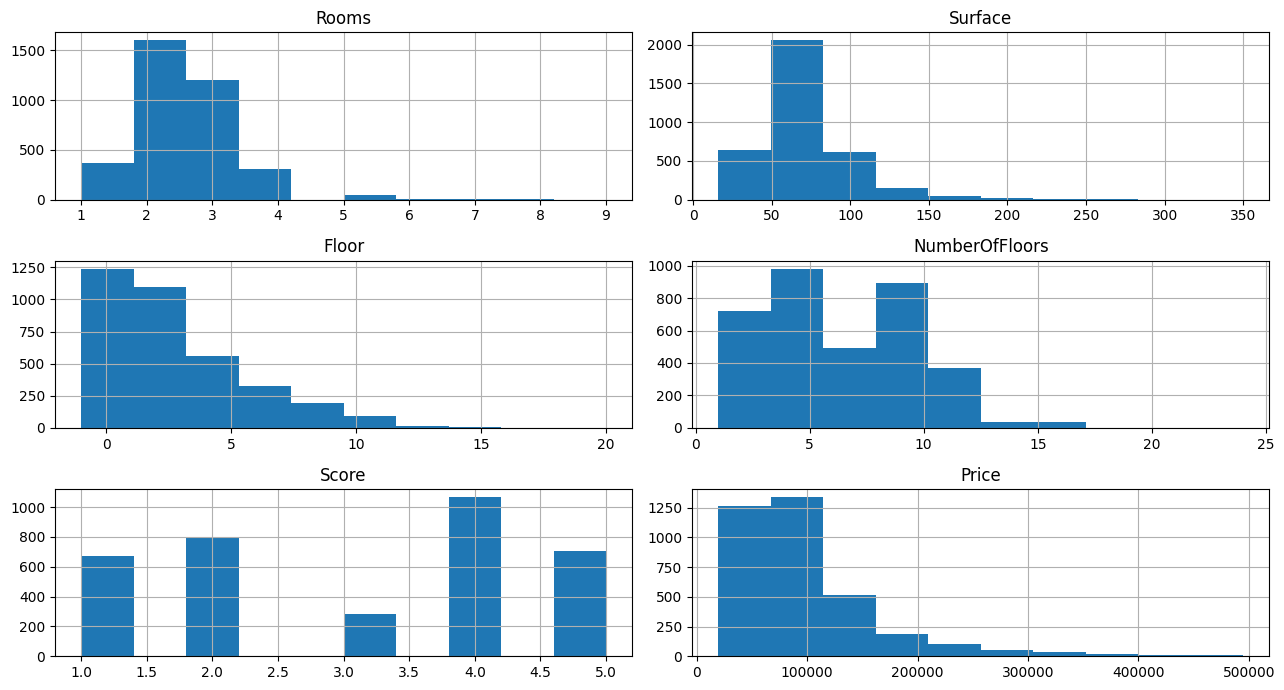

In [444]:
# Creating the plot
fig = plt.figure(figsize=(13,7))

# Getting the number of axes
ax = fig.gca()
# Creating the histograms with the number of axes
df.hist(ax=ax)

plt.tight_layout()

The graph shows the distribution of the data and pretty much confirms what the basic summary statistics described previously. One thing that is hard to take out from the histograms is the presence of outliers in the dataset.

##### Checking for outliers in the data

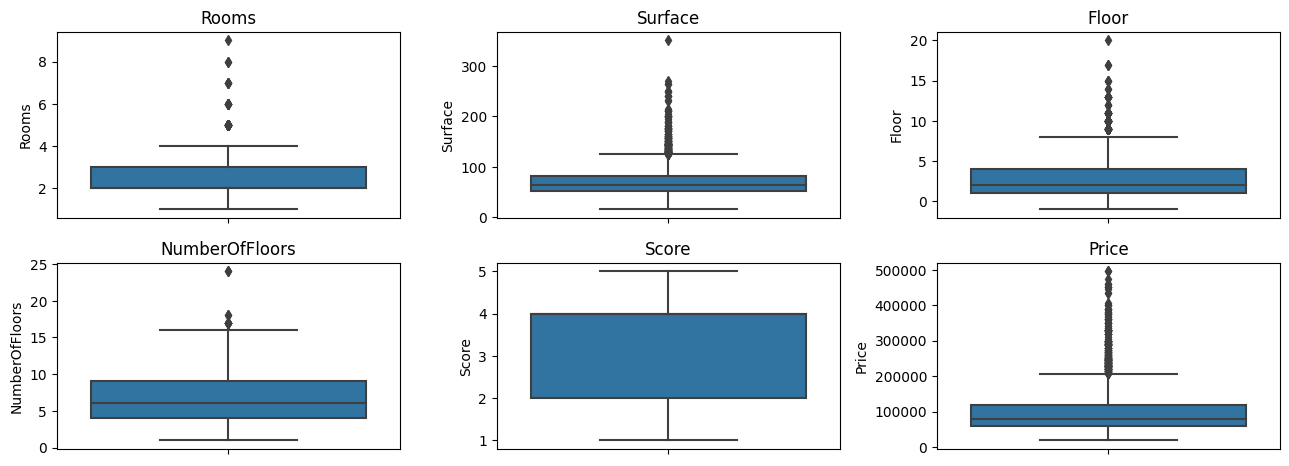

In [162]:
# Creating the plot
plt.figure(figsize=(13,7)) 

# Removing the area category
df_boxplot = df.drop(['AreaLocation'], axis=1)

# Creating a different subplot for all the columns
for i in range(0,len(df_boxplot.columns)):
    plt.subplot(3,3,i+1)
    # Creating the Boxplots
    sns.boxplot(data=df_boxplot, y=df_boxplot.columns[i])
    plt.title(f'{df_boxplot.columns[i]}')
    plt.tight_layout()

The Boxplots are another way visualize the distribution of the data. The graphs display the min, first quartile (Q1), median, third quartile (Q3) and max values, with the outliers being shown by the red diamond figures, telling us that all, except the <code>Score</code>, columns have some outliers, especially the <code>Surface</code> and the <code>Price</code>. 

### Understanding the data

In order to understand about what kind of apartments the data is all about, we can take a more detailed look at the prices of the estates in the dataset, as well their other proportions.

The previous boxplot visualizations showed us where the outliers are in each variable and for a more detailed analysis, the bottom visualizations will zoom in and focus on the more concentrated value areas.

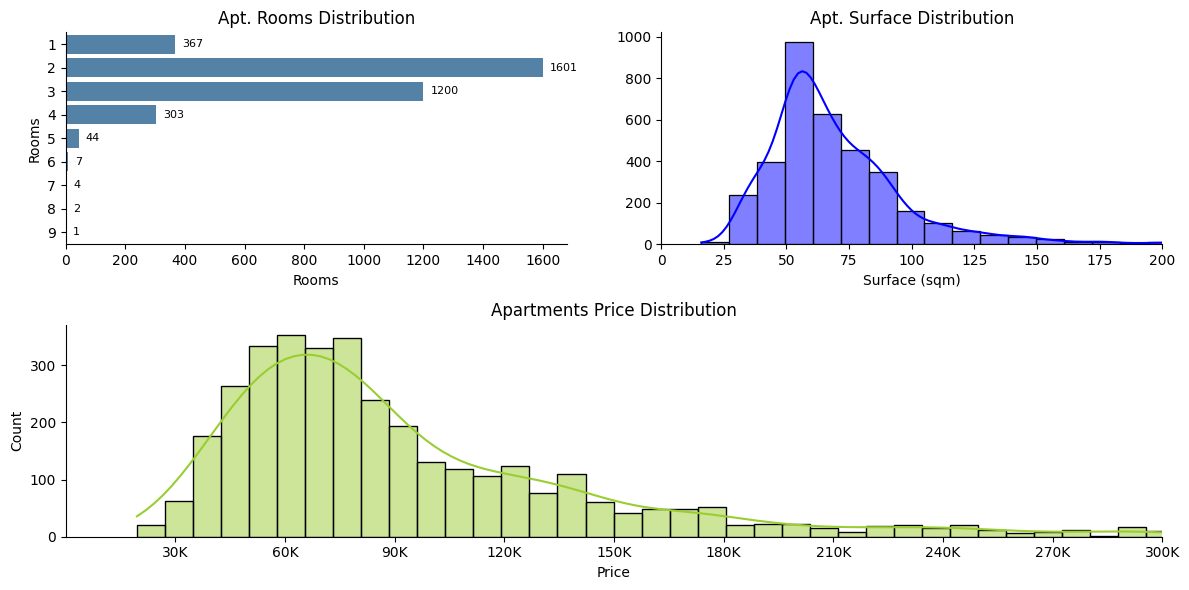

In [253]:
# Creating the plot
plt.figure(figsize=(12, 6))

# Visualizing the distribution of the number of rooms 
plt.subplot(221)
rooms_plot = sns.countplot(data=df, y='Rooms', color='steelblue')
# Adding value labels to the bins
for bar in rooms_plot.containers:
    rooms_plot.bar_label(bar, padding=5, fontsize=8)
plt.xlabel('Rooms')
plt.title("Apt. Rooms Distribution")

# Visualizing the distribution of the surface 
plt.subplot(222)
sns.histplot(data=df, x='Surface', kde=True, bins=30, color='blue').set_xlim(0,200)
plt.xlabel('Surface (sqm)')
plt.ylabel(' ')
plt.title("Apt. Surface Distribution")

# Visualizing the distribution of prices 
plt.subplot(212)
sns.histplot(data=df, x='Price', kde=True, color='yellowgreen').set_xlim(0,300000)
plt.xlabel('Price')
plt.title("Apartments Price Distribution")
plt.xticks([30000, 60000, 90000, 120000, 150000, 180000, 210000, 240000, 270000, 300000],
           ['30K', '60K', '90K','120K', '150K', '180K','210K', '240K', '270K', '300K'])

sns.despine()
plt.tight_layout()

The visualizations show that most apartments in the dataset are containing two rooms, mostly with about surface of 60 squared meters and are most likely to be in the price range of about 45.000 to about 85.000. Both the Apartments Surface and Price distributions, visualized in the graph, seem to be right skewed.

Data skewed to the right is usually a result of a lower boundary in the data set. If the data set's lower bounds are lower relative to the rest of the data, this will cause the data to skew right, as it is in this case, with most apartments being concentrated within the lower price ranges and having a few of them with much bigger prices, causing the data to skew right.

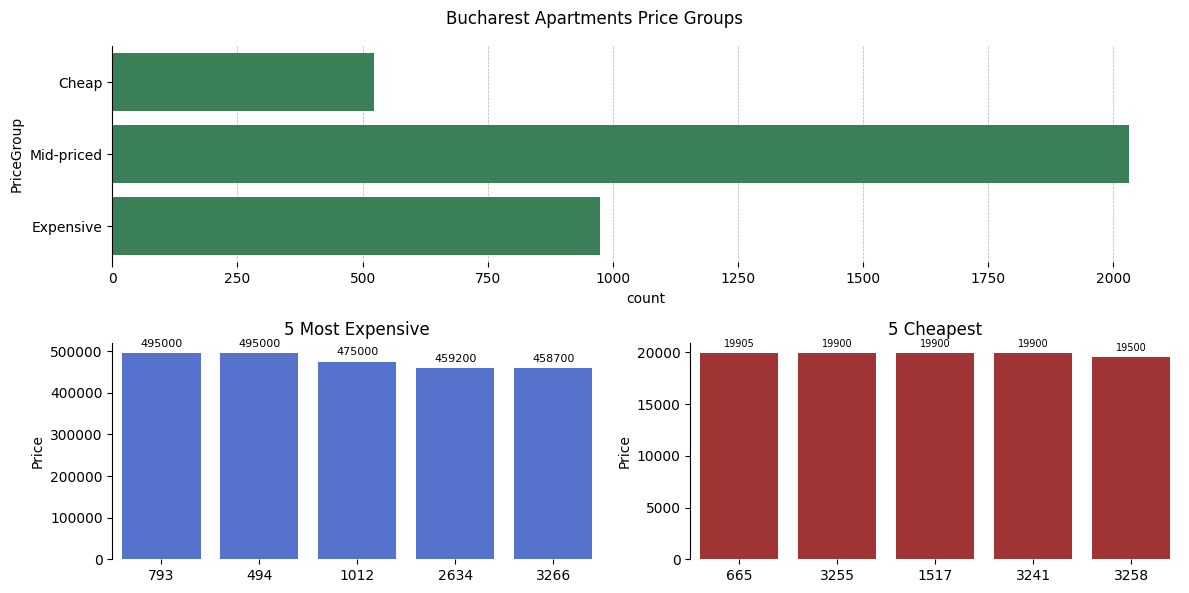

In [61]:
# Retrieving the top and last 5 apts in terms of price 
top_5 = df.sort_values(by='Price', ascending=False).head()
last_5 = df.sort_values(by='Price', ascending=False).tail()

# Creating the plot
plt.figure(figsize=(12, 6))

# Counting the price groups
plt.subplot(211)
sns.countplot(data=df, y='PriceGroup', color='seagreen').set_axisbelow(True)
plt.grid(axis = 'x', linewidth=0.5, linestyle='dashed')

# Top 5 most expensive apartments
plt.subplot(223)
fig2 = sns.barplot(data=top_5, x=top_5.index, y='Price', color='royalblue', order=top_5.index)
fig2.set(title='5 Most Expensive')
for bar in fig2.containers:
    fig2.bar_label(bar, padding=3, fontsize=8)

# Last 5 cheapest apartments
plt.subplot(224)
fig3 = sns.barplot(x=last_5.index, y='Price', data=last_5, color='firebrick', order=last_5.index)
fig3.set(title='5 Cheapest')
for bar in fig3.containers:
    fig3.bar_label(bar, padding=3, fontsize=7)

plt.suptitle('Bucharest Apartments Price Groups')
sns.despine(bottom=True)
plt.tight_layout()

The graph above shows that most apartments in the dataset lie within the Mid-priced range being 50K-110K, followed by the Expensive apartments being above the price 110K, and finally the Cheap ones under 50K. As previously mentioned the distribution of the prices data is right skewed and here it can be seen that the range from the 5 cheapest apartments to the 5 most expensive ones is quite big.

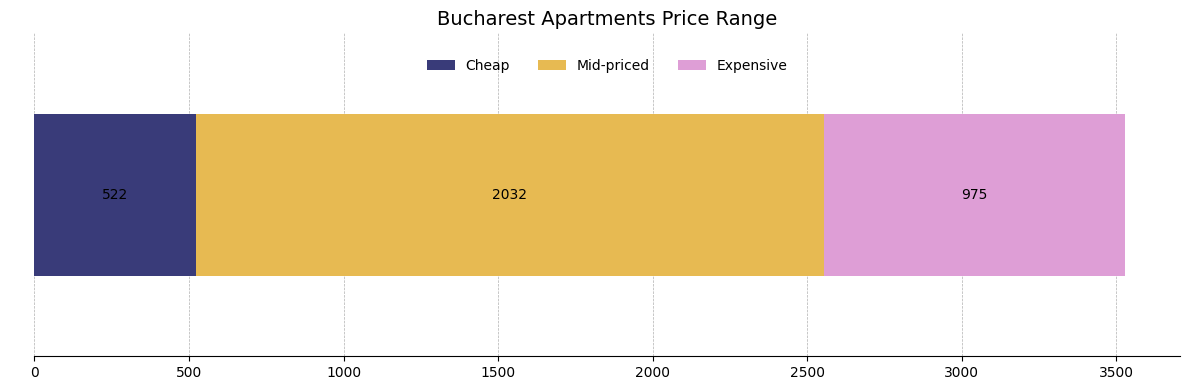

In [63]:
# Counting the apartments in the correspondent price groups
df_price = df.groupby('PriceGroup').size().reset_index()
# Transposing the dataframe
df_price = df_price.transpose()
# Setting the column headers
df_price.columns = df_price.iloc[0]
df_price = df_price.iloc[pd.RangeIndex(len(df_price)).drop(0)]

# Plotting the price groups
df_price.plot(kind='barh', stacked=True, colormap='tab20b', figsize=(12, 4)).set_axisbelow(True)
plt.grid(axis = 'x', linewidth=0.5, linestyle='dashed')
plt.legend(bbox_to_anchor=(0.5, 0.9), loc="center", borderaxespad=0, frameon=False, ncol=3)
plt.title("Bucharest Apartments Price Range", fontsize=14)
plt.ylabel(' ')
plt.yticks([ ])
# Labeling the values to the bars
for ix, row in df_price.iterrows():
        cumulative = 0
        for element in row:
                plt.text(cumulative + element / 2, ix, f"{element}", va="center", ha="center",)
                cumulative += element

sns.despine(left=True)
plt.tight_layout()

The graph above confirms what the previous visualization showed, the way the apartments price ranges are distributed, this time displaying the actual number of apartments in the dataset within the correspondet price range.

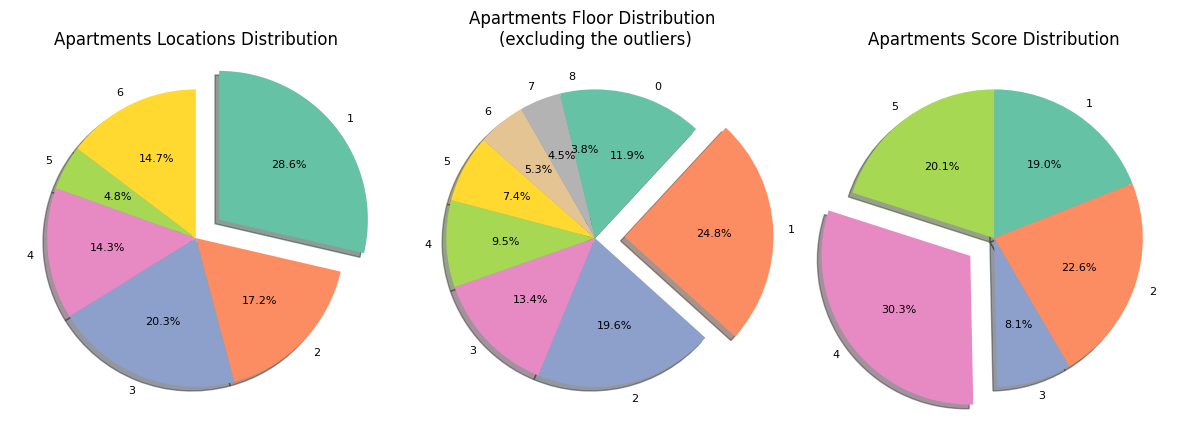

In [69]:
# Creating the plot
plt.figure(figsize=(12, 6))

# Visualizing the distribution of area locations 
plt.subplot(131)
df.groupby('AreaLocation').size().plot(kind='pie', 
                                       startangle = 90, 
                                       explode = [0.2, 0, 0, 0, 0, 0],
                                       shadow = True,
                                       autopct='%1.1f%%',
                                       counterclock=False,
                                       colors=sns.color_palette('Set2'),
                                       textprops={'fontsize': 8})
plt.title("Apartments Locations Distribution")

# Visualizing the distribution of floor locations
plt.subplot(132)
# Removing the floors outliers
floors_plot = df.groupby('Floor').size()
floors_plot = floors_plot[floors_plot > 67]
# Plotting the floors distribution
floors_plot.plot(kind='pie', 
                startangle = 90,        
                autopct='%1.1f%%',
                counterclock=False,
                explode = [0, 0.2, 0, 0, 0, 0, 0 , 0, 0],
                shadow = True,
                colors=sns.color_palette('Set2'),
                textprops={'fontsize': 8})
plt.title("Apartments Floor Distribution \n(excluding the outliers)")

# Visualizing the distribution of scores 
plt.subplot(133)
df.groupby('Score').size().plot(kind='pie', 
                                startangle = 90, 
                                autopct='%1.1f%%',
                                counterclock=False,
                                explode = [0, 0, 0, 0.2, 0],
                                shadow = True,
                                colors=sns.color_palette('Set2'),
                                textprops={'fontsize': 8})
plt.title("Apartments Score Distribution")

plt.tight_layout()

The graph shows that most of the aparments in the dataset are located in area 1, closely followed by area 2, with the majority of them being situated on the first floor or the lower floors in general and are most likely to have a score of 4 points.

##### Analyzing the relationship between the variables

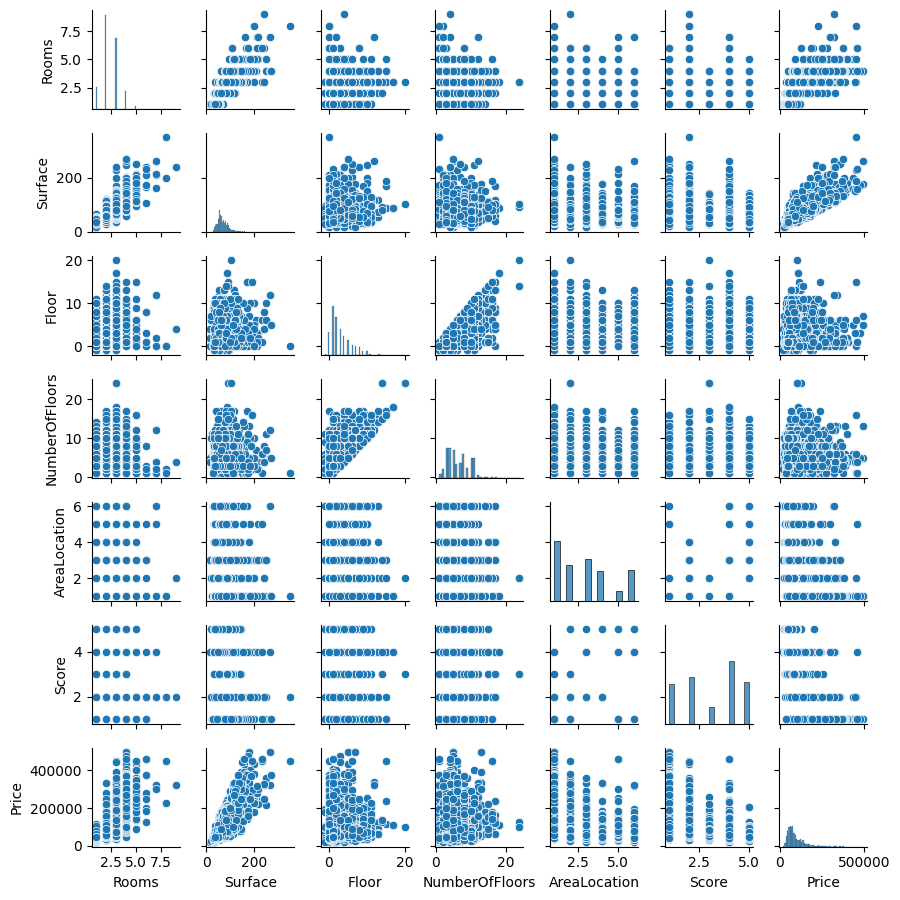

In [71]:
# Creating a pairplot
sns.pairplot(df, size = 1.3)
plt.tight_layout()

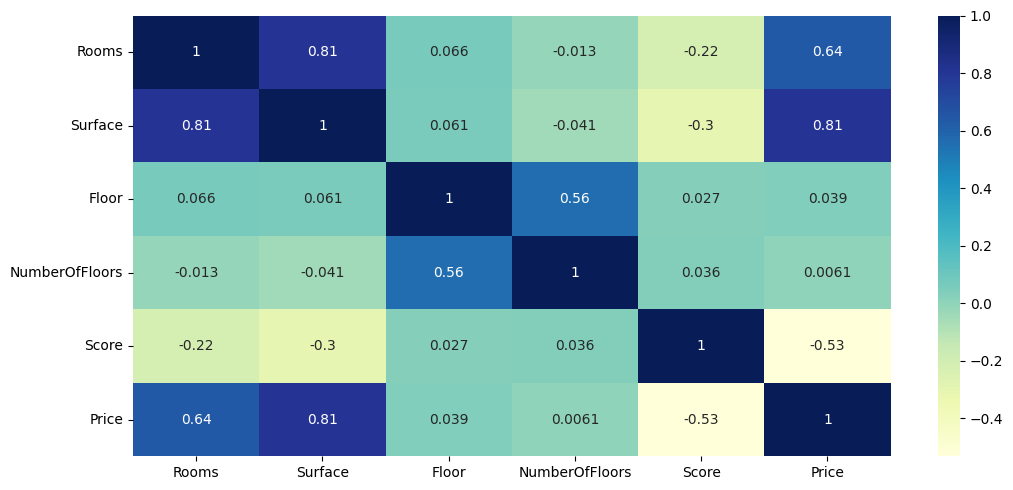

In [20]:
# Creating a correlation matrix
plt.figure(figsize=(11,5))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
plt.tight_layout()

The correlation analysis shows that there seems to be strong correlation between the price of the apartment and the surface area (0.81), as well as between the price and the number of rooms (0.64). Another two correlations that can be found is between the number of floors in the building and the actual floor of the estate, and the area location and the score of the estate.

##### Analyzing the price correlationship

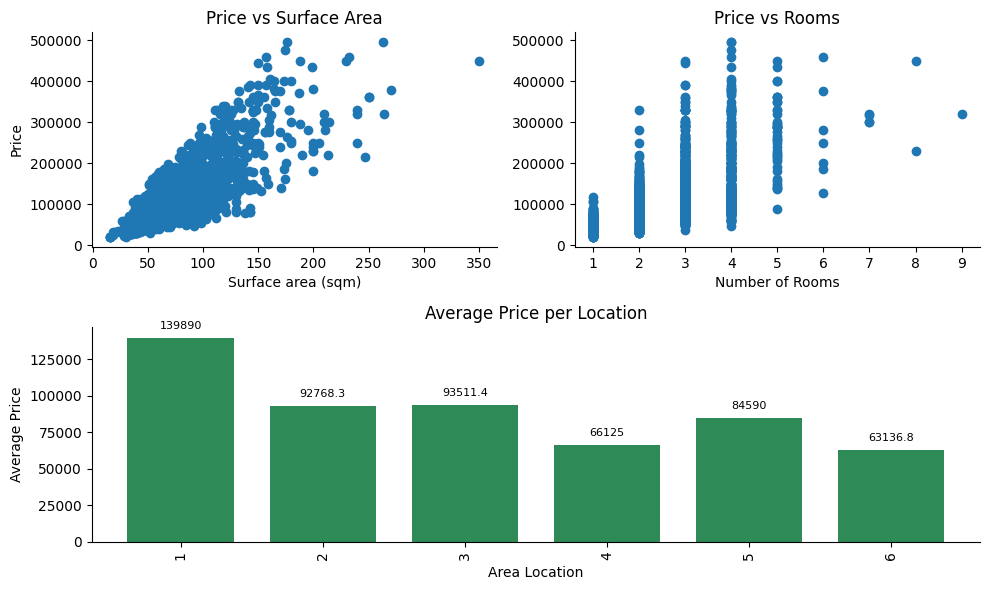

In [7]:
# Creating the plot
plt.figure(figsize=(10, 6))

# Scatter plot for Price vs Surface
plt.subplot(221)
plt.scatter(data=df, x='Surface', y='Price')
# Adding labels to the plot
plt.xlabel('Surface area (sqm)')
plt.ylabel('Price')
plt.title('Price vs Surface Area')

# Scatter plot for Price vs Rooms
plt.subplot(222)
plt.scatter(data=df, x='Rooms', y='Price')
# Adding labels to the plot
plt.xlabel('Number of Rooms')
plt.title('Price vs Rooms')

# Bar plot for the Average Price in Locations
plt.subplot(212)
x = df.groupby('AreaLocation')['Price'].mean()
locations_plot= x.plot(kind='bar', width = 0.75, color='seagreen')
# Adding labels to the plot
for bar in locations_plot.containers:
    locations_plot.bar_label(bar, padding=5, fontsize=8)
plt.xlabel('Area Location')
plt.ylabel('Average Price')
plt.title('Average Price per Location')

sns.despine()
plt.tight_layout()

Unsurprisingly, the scatter plots show that the price increases with the number of rooms and the squared metres surface area of the estate. The barplot at the bottom of the graph tells us that the most expensive area is located in zone 1.

#### Analyzing the prices of apartments

In [435]:
# Defining a function for calculating the average price
def avg_price(variable):
    """
    Definition: 
        Calculates the average price for the given variable
    
    Arguments: 
        variable (str): Another column present in the dataframe (i.e. Rooms, Score, Floor, Surface, etc.)
    
    """
    # Calculating the mean price for every other variable
    x = df.groupby(variable)['Price'].mean()
    # Creating the plot
    x.plot(kind='bar')
    plt.title(f'Avg price per {variable}')
    plt.ylabel('Mean Price')
    # Removing the X value labels for the 'Surface' variable due to too many possible values
    if variable == 'Surface':
        plt.xticks([])
    sns.despine()
    plt.tight_layout()

# Displaying the function
help(avg_price)

Help on function avg_price in module __main__:

avg_price(variable)
    Definition: 
        Calculates the average price for the given variable
    
    Arguments: 
        variable (str): Another column present in the dataframe (i.e. Rooms, Score, Floor, Surface, etc.)



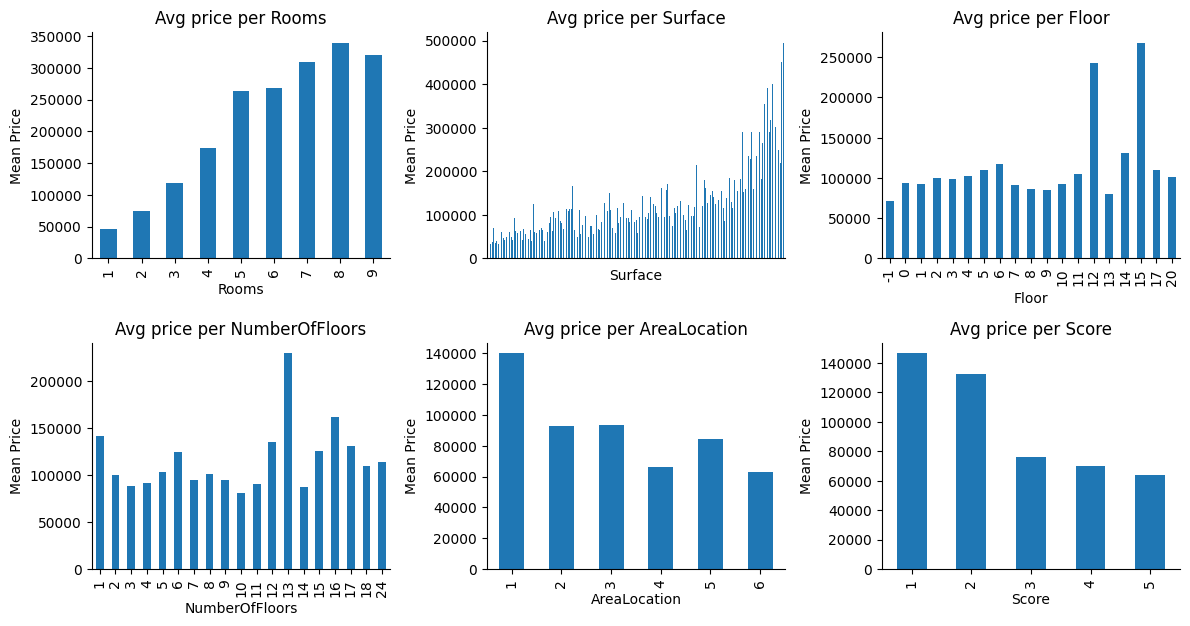

In [122]:
# Creating the plot
plt.figure(figsize=(12,9))

# Removing the price column
df_price = df.drop(['Price'], axis=1)

# Creating a different subplot for all the columns
for i in range(0,len(df_price.columns)):
    plt.subplot(3,3,i+1)
    # Creating the Boxplots
    avg_price(df_price.columns[i])
    

Once again, it can be seen that the most expensive apartments in the dataset are located in Bucharest Area 1. The bigger the number of rooms and higher surface area of the apartment is also an indicator for higher price.

##### Analyzing the Areas Locations

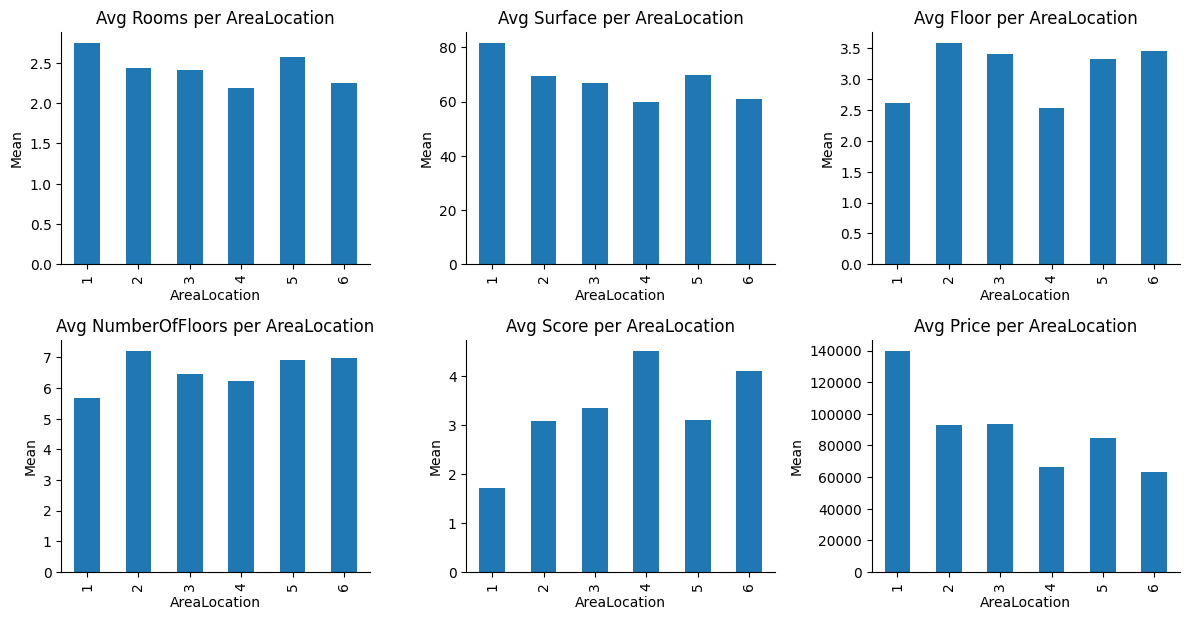

In [440]:
# Creating the plot
plt.figure(figsize=(12,9)) 

# Creating a different subplot for all the columns
for i in range(0,len(df_boxplot.columns)):
    plt.subplot(3,3,i+1)
    # Creating the Boxplots
    x = df.groupby('AreaLocation')[df_boxplot.columns[i]].mean()
    x.plot(kind='bar')
    plt.title(f'Avg {df_boxplot.columns[i]} per AreaLocation')
    plt.ylabel('Mean')
    sns.despine()
    plt.tight_layout()

The graph provides an answer to the question why are the most expensive apartments in the dataset located in Area 1, and that is because the estates there seem to have the most amount of rooms on average and the highest surface area on average, and those are exactly the attributes of an apartment that are highly correlated with the price, as previously seen in the correlation analysis.

## Machine Learning

### Data preparation

Machine learning models require all input and output variables to be numeric. That is why the categorical data needs to be encoded into integer format so that the data with converted categorical values can be provided to the models.

In [7]:
# Dropping the previously created price group column
df.drop(['PriceGroup'], axis = 1, inplace = True)

# Dummy encoding
encoded = pd.get_dummies(df['AreaLocation'], prefix='Area')
# Entering the encoded values
df_2 = pd.concat([df, encoded], axis=1)
# Dropping the previous categorical values
df_2.drop('AreaLocation', axis = 1, inplace = True)

df_2

,Rooms,Surface,Floor,NumberOfFloors,Score,Price,Area_1,Area_2,Area_3,Area_4,Area_5,Area_6
0,4,108.00,2,3,5,83000,0,0,0,1,0,0
1,1,41.00,1,8,1,39900,1,0,0,0,0,0
2,3,63.52,1,3,3,84900,0,1,0,0,0,0
3,1,33.00,3,10,1,45500,0,0,0,0,1,0
4,2,62.00,5,9,5,54900,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3524,3,102.00,2,5,1,189000,1,0,0,0,0,0
3525,4,96.00,1,3,2,200000,0,0,1,0,0,0
3526,1,35.00,1,3,5,47000,0,0,0,1,0,0
3527,2,60.00,6,7,2,89500,1,0,0,0,0,0


The data's numerical features now need to be standardised. This technique is to re-scale the values with the distribution value between 0 and 1 and is useful for the optimization of algorithms.

In [8]:
# Creating the scaler object
scaler = StandardScaler()
# Standatization
numerical_features = ['Rooms', 'Surface', 'Floor', 'NumberOfFloors', 'Score']
df_2[numerical_features] = scaler.fit_transform(df_2[numerical_features])

df_2

,Rooms,Surface,Floor,NumberOfFloors,Score,Price,Area_1,Area_2,Area_3,Area_4,Area_5,Area_6
0,1.740554,1.313061,-0.398658,-1.085913,1.318252,83000,0,0,0,1,0,0
1,-1.659307,-0.990703,-0.764552,0.498290,-1.454162,39900,1,0,0,0,0,0
2,0.607267,-0.216363,-0.764552,-1.085913,-0.067955,84900,0,1,0,0,0,0
3,-1.659307,-1.265779,-0.032764,1.131971,-1.454162,45500,0,0,0,0,1,0
4,-0.526020,-0.268628,0.699025,0.815131,1.318252,54900,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3524,0.607267,1.106754,-0.398658,-0.452232,-1.454162,189000,1,0,0,0,0,0
3525,1.740554,0.900447,-0.764552,-1.085913,-0.761059,200000,0,0,1,0,0,0
3526,-1.659307,-1.197010,-0.764552,-1.085913,1.318252,47000,0,0,0,1,0,0
3527,-0.526020,-0.337397,1.064919,0.181449,-0.761059,89500,1,0,0,0,0,0


After the categorical data has been encoded and the numerical standartized, the target variable must be specified. Features are the independent variables, while the target variable is the dependent variable or the measure we're trying to predict.

In [9]:
# Selecting the target and the features
target = df_2['Price'].values.reshape(-1,1)
features = df_2.drop('Price', axis = 1).values

# Printing the shapes
print(features.shape, target.shape)

(3529, 11) (3529, 1)


The available data now needs to be split into training and testing batches. The simplest way to split the modelling dataset into training and testing sets is to assign a 2/3 ratio. Therefore, we train the model using the training set and then apply the model to the test set. In this way, we can evaluate the performance of the model.

In [10]:
# Splitting the data into a training set of 80% and a testing set of 20%
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42, shuffle = True)

In [11]:
# Printing the shapes of the datasets
print(f"Shape of the training set: {X_train.shape}")
print(f"Shape of the test set: {X_test.shape}")

Shape of the training set: (2823, 11)
Shape of the test set: (706, 11)


### Running regression models on the data

In [12]:
# Creating a function that will be used to fit and evaluate the models
def score_reg_model(reg):
    """
    Definition: 
        Fits the given model and calculates the MAE, RMSE and R2
    
    Arguments: 
        reg (str): Regression model to be fitted and scored
    """
    # Training the model on the training dataset
    reg.fit(X_train, y_train)
    # Testing the model with the test data
    y_pred = reg.predict(X_test)
    # Calulating the mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    # Calulating the root mean squared error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # Calculating the coefficient of determination (r squared)
    r2 = r2_score(y_test, y_pred)
    # Returns the calculated metrics
    return mae, rmse, r2

# Displaying the function
help(score_reg_model)

Help on function score_reg_model in module __main__:

score_reg_model(reg)
    Definition: 
        Fits the given model and calculates the MAE, RMSE and R2
    
    Arguments: 
        reg (str): Regression model to be fitted and scored



Next we’ll create a Pandas dataframe into which we’ll store the data. Then we’ll loop over each of the regression models, fit it using the X_train and y_train data, then generate predictions from X_test and calculate the metrics for evaluation.

In [16]:
# Listing all the regression models to be used on the data
regressors = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), LassoLars(), BayesianRidge(), SGDRegressor()]

# Creating a DataFrame to display the regressors scores
regs_df = pd.DataFrame(columns=["Model", "MAE", "RMSE", "R2"])

# Scoring the regressors
for reg in regressors:
    # Retrieving the name of model
    name = reg.__class__.__name__
    # Calculating the metrics
    mae, rmse, r2 = score_reg_model(reg)
    # Adding the results to the Dataframe
    entry = pd.DataFrame([[name, mae, rmse, r2*100]], columns=["Model", "MAE", "RMSE", "R2"])
    regs_df = regs_df.append(entry)

In [32]:
# Displaying the dataframe with the results
regs_df

,Model,MAE,RMSE,R2
0,LinearRegression,21016.561243,31585.748983,76.914323
0,Ridge,21014.518062,31585.408722,76.914820
0,Lasso,21016.050506,31585.693676,76.914404
0,ElasticNet,22971.488751,35843.057262,70.271681
0,LassoLars,21016.050111,31585.694385,76.914402
0,BayesianRidge,21009.737088,31584.754350,76.915777
0,SGDRegressor,21240.552018,31664.116566,76.799625


* Mean Absolute Error (MAE) is the average of the difference between the actual value and the predicted one. It measures how far the predictions are from the actual output. The lower the MAE, the better the model.

* Root Mean Squared Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are and RMSE is a measure of how spread out these residuals are. Good RMSE values should be as low as possible.

* The R2 (coefficient of determination) is a measure of how well the regression line approximates the actual data. It is a measure that provides probably the most needed information about the goodness of fit of a regression model.

Due to the previously mentioned reasons, we will take a closer look at coefficient of determination of the models. It is in general more informative than MAE and RMSE in regression analysis evaluation, as the former can be expressed as a percentage, whereas the latter measures have arbitrary ranges.

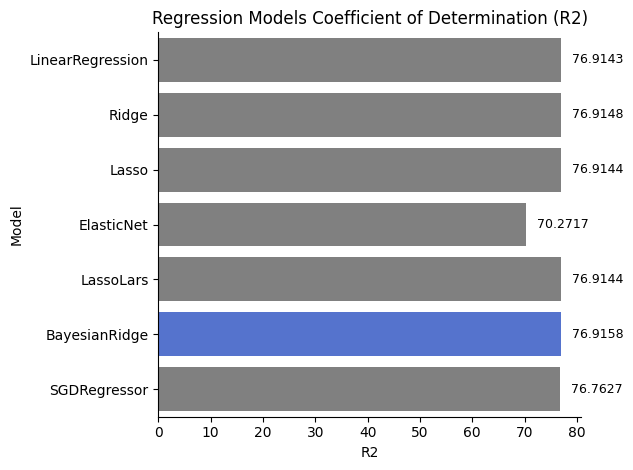

In [13]:
# Highlighting the highest value of R2
clrs = ['grey' if (x < max(regs_df['R2'])) else 'royalblue' for x in regs_df['R2'] ]
# Plotting the models scores
regs_plot = sns.barplot(data=regs_df, x='R2', y='Model', palette=clrs)
plt.title('Regression Models Coefficient of Determination (R2)')
# Adding the data values to the columns
for bar in regs_plot.containers:
    regs_plot.bar_label(bar, padding=8, fontsize=9)

sns.despine()
plt.tight_layout()

As the graph indicates, the model with the highest coefficient of determination, altough not by far, is the Bayesian Ridge with R2 score of 76.9158 (0.76).

### Analyzing the results of the Bayesian Ridge Regression

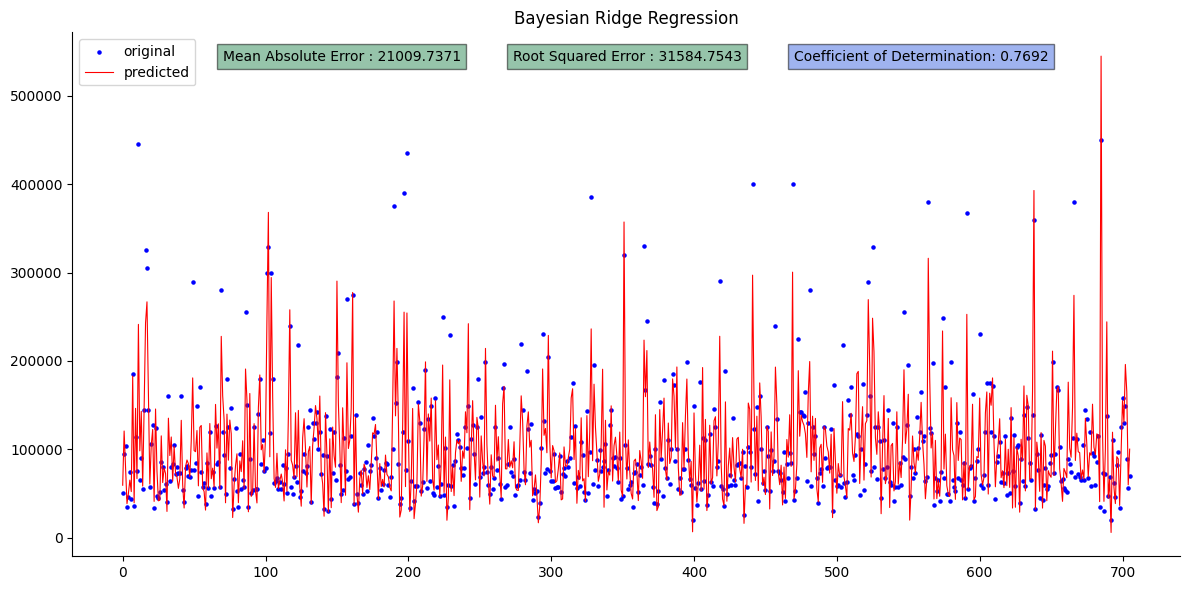

In [159]:
# Retrieving the scores for the Bayesian Ridge model
mae, rmse, r2 = score_reg_model(BayesianRidge())
# Rounding the scores
mae, rmse, r2 = round(mae,4),round(rmse,4),round(r2,4)

# Creating the graph
plt.figure(figsize=(12, 6))

# Plotting the metrics
plt.text(70, 540000, s=f'Mean Absolute Error : {mae}', size = 10, bbox=dict(facecolor='seagreen', alpha=0.5))
plt.text(273, 540000, s=f'Root Squared Error : {rmse}', size = 10, bbox=dict(facecolor='seagreen', alpha=0.5))
plt.text(470, 540000, s=f'Coefficient of Determination: {r2}', size = 10, bbox=dict(facecolor='royalblue', alpha=0.5))

# Plotting the regression predictions
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.title("Bayesian Ridge Regression")
plt.legend()

sns.despine()
plt.tight_layout() 

## Optimizing the model performance

### Feature Engineering

Feature engineering allows us to extract relevant information from the raw data and transform it into useful representation that can capture the underlying patterns and relationships in the data. This can help the model to better understand the problem and make more accurate predictions.

In [6]:
# Calculating price per square meter
df['PricePerSqm'] = df['Price'] / df['Surface']

# Calculating the size of the rooms
df['RoomsSize'] = df['Rooms'] / df['Surface']

# Calculating the floor to building's floors ratio
df['FloorRatio'] = df['Floor'] / df['NumberOfFloors']

Now that the we have chosen the Baysian Ridge Regression model and more valuable information has been extracted from the available data, such as <code>RoomSize</code> as the size of the rooms in the apartment, or the <code>PricePerSqm</code> as the price per sqm surface area, we need to prepare the data again the same way for the model to train on and see if the results have gotten better with the newly extracted information from the feature engineering.

In [24]:
# Creating the df for the model 
df_2 = pd.concat([df, encoded], axis=1)
# Dropping the previous categorical values
df_2.drop('AreaLocation', axis = 1, inplace = True)

# Standatization of the original and newly created features 
numerical_features = ['Rooms', 'Surface', 'Floor', 'NumberOfFloors', 'Score','PricePerSqm',	'RoomsSize', 'FloorRatio']
df_2[numerical_features] = scaler.fit_transform(df_2[numerical_features])

# Selecting the new features
new_features = df_2.drop('Price', axis = 1).values

# Splitting the new data into a training set of 80% and a testing set of 20%
X_train, X_test, y_train, y_test = train_test_split(new_features, target, test_size = 0.2, random_state = 42, shuffle = True)

In [22]:
# Creating the model
model= BayesianRidge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calulating the new metrics
mae_opt = mean_absolute_error(y_test, y_pred)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred))
r2_opt = r2_score(y_test, y_pred)

# Printing the new metrics
print(f"Mean Absolute Error: {mae_opt}")
print(f"Root Mean Squared Error: {rmse_opt}")
print(f"Coefficient of Determination (R squared): {r2_opt}")

Mean Absolute Error: 8871.518727913914
Root Mean Squared Error: 14811.533998592362
Coefficient of Determination (R squared): 0.9492354732660079


As it can be seen the feature engineering has significantly improved the performance and robustness of the model, and prooves that creating new features or transforming the existing ones can help improve the model's performance by capturing more complex patterns and relationships in the data.

### Analyzing the results of the optimized Bayesian Ridge Regression

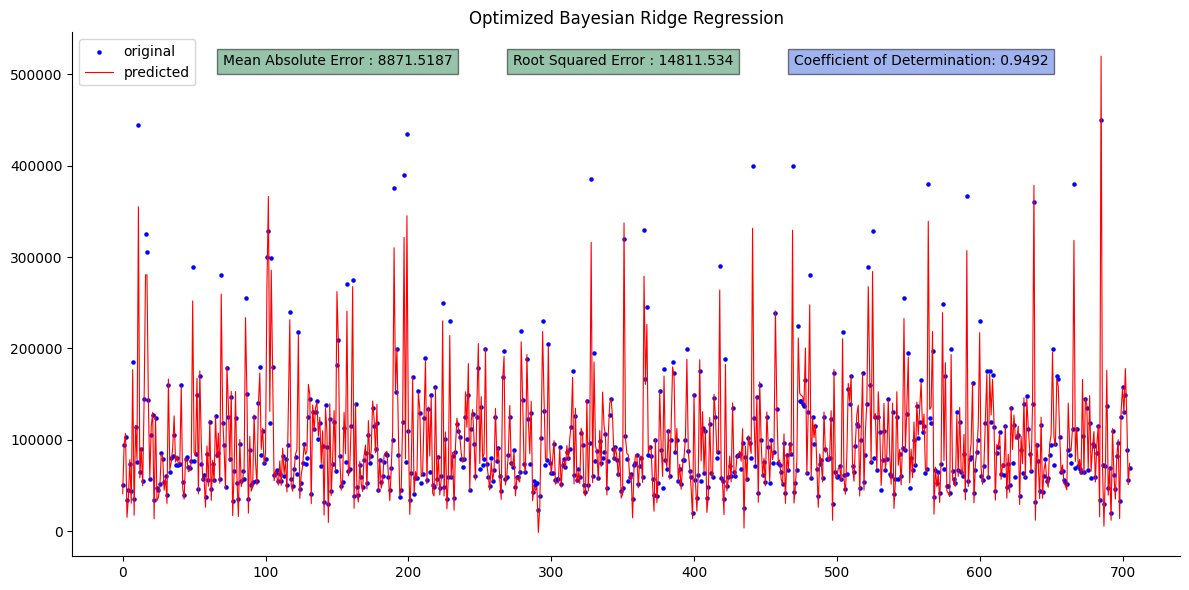

In [23]:
# Rounding the scores
mae_opt, rmse_opt, r2_opt = round(mae_opt,4),round(rmse_opt,4),round(r2_opt,4)

# Creating the graph
plt.figure(figsize=(12, 6))

# Plotting the metrics
plt.text(70, 510000, s=f'Mean Absolute Error : {mae_opt}', size = 10, bbox=dict(facecolor='seagreen', alpha=0.5))
plt.text(273, 510000, s=f'Root Squared Error : {rmse_opt}', size = 10, bbox=dict(facecolor='seagreen', alpha=0.5))
plt.text(470, 510000, s=f'Coefficient of Determination: {r2_opt}', size = 10, bbox=dict(facecolor='royalblue', alpha=0.5))

# Plotting the regression predictions
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.title("Optimized Bayesian Ridge Regression")
plt.legend()

sns.despine()
plt.tight_layout() 


### Conclusion

The project demonstrates how statistical analysis and machine learning models can be used to predict housing prices based on different features. The notebook also shows the importance of data cleaning, visual analyses and feature engineering in preparing data for machine learning models and gaining valuable insights from it.

The analysis explores the relationships between the different variables with the purpose of identifying any interesting patterns or trends in the data and provides insights into the factors that affect apartment prices in Bucharest. It also demonstrates that a Bayesian Ridge regression model can be an effective tool for predicting apartment prices based on these factors.

Overall, by performing different visualizations and analyses, this project provides insights into the factors affecting housing prices in Bucharest, Romania and demonstrates the potential of data analytics and machine learning algorithms in predicting real estate prices. 

***
Made By: Plamen Angelov
***